# MNISTデータセットのニューラルネットによる分類をPyTorchを用いて実装した例

* **このノートブックはGPUを有効にしておかないと実行に非常に時間がかかるので注意**
* GPUはColabの画面上にあるメニューの [ランタイム] -> [ランタイムのタイプを変更] から設定可能

## モジュールのインストール
Google Colabに標準でインストールされていないモジュールを最初にインストールしておく

In [1]:
!pip install torchviz
!pip install japanize-matplotlib

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=cd702616ac5cc906056897951fbf31f97162d7ace90daf428a7e0338a31e557c
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=699571b8ea84357dfb7ffc185dce2acf6180073e2e3c4291556022d1d9165f7f
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


## 必要なモジュールの読み込み

* 可視化用のモジュール (Matplotlib) と自動微分の計算用モジュール (PyTorch)， およびPyTorchで画像を扱うためのモジュール (TorchVision)
* GPUが利用可能か判定し，可能な場合は利用するデバイスの種類をGPUに切り替える

In [2]:
from collections import OrderedDict

from tqdm import tqdm
from matplotlib import pyplot as plt
import japanize_matplotlib

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms as T


print('PyTorch version: ' + torch.__version__)
print('TorchVision version: ' + torchvision.__version__)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Device: ' + str(device))

PyTorch version: 2.1.0+cu121
TorchVision version: 0.16.0+cu121
Device: cpu


## データの準備とプロット

TorchVision の中に準備されている MNIST データセット (訓練データ60000件，テストデータ10000件) を用いる．各画像は28×28ピクセルなのでデータの次元数は784になる．

* MNISTデータベース - Wikipedia
    * https://ja.wikipedia.org/wiki/MNISTデータベース
* MNIST — Torchvision 0.16 documentation
    * https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html

In [3]:
train_data = datasets.MNIST('./data', train=True, download=True)
test_data = datasets.MNIST('./data', train=False, download=True)

train_data, test_data

100%|██████████| 9912422/9912422 [00:00<00:00, 69056907.64it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 53059874.65it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 15762751.36it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9626340.96it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test)

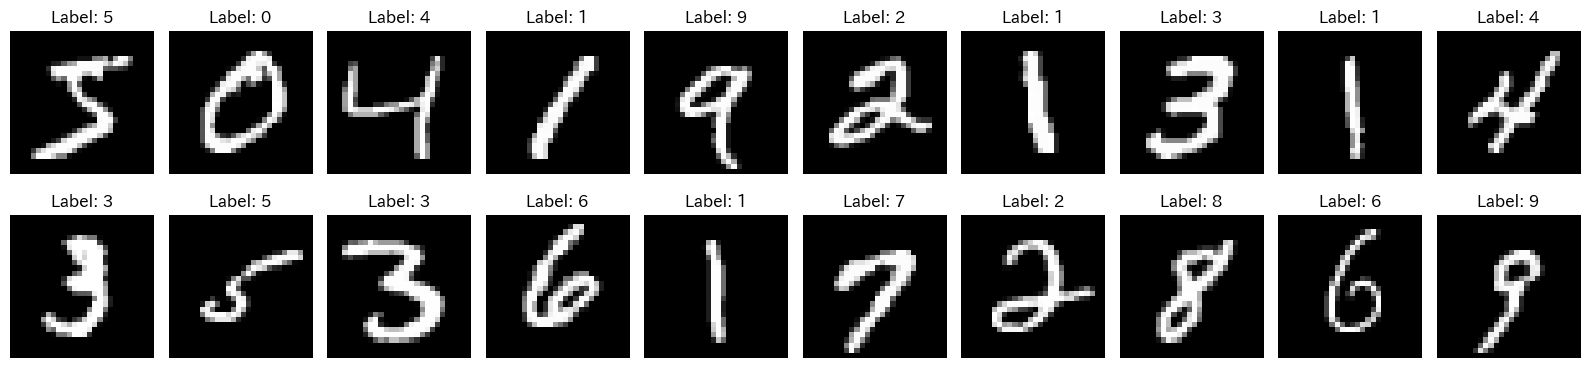

In [4]:
plt.figure(figsize=(16, 4))

for k in range(20):
    img, label = train_data[k]

    plt.subplot(2, 10, k + 1)
    plt.imshow(img, cmap='gray')
    plt.title('Label: ' + str(label))
    plt.axis('off')

plt.tight_layout()  # スペースの調整

## データの標準化

データセットの平均 $\mu$ と標準偏差 $\sigma$ を計算し，各データについて変換：

$$
z = \frac{x - \mu}{\sigma}
$$

をかける準備をする．

100%|██████████| 60000/60000 [00:15<00:00, 3750.33it/s]


(-0.5, 27.5, 27.5, -0.5)

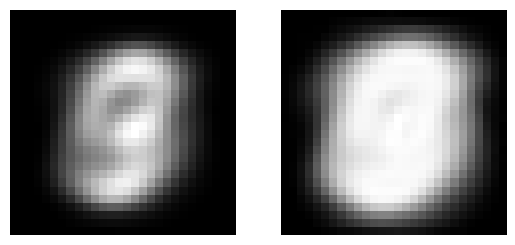

In [5]:
img_mean = torch.zeros((28, 28))
for k, (data, label) in tqdm(enumerate(train_data), total=len(train_data)):
    img_mean += T.ToTensor()(data)[0]
img_mean /= len(train_data)

img_var= torch.zeros((28, 28))
for k, (data, label) in tqdm(enumerate(train_data), total=len(train_data)):
    img_var += (T.ToTensor()(data)[0] - img_mean) ** 2
img_var /= len(train_data)
img_std = torch.sqrt(img_var)

plt.subplot(1, 2, 1)
plt.imshow(img_mean, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_std, cmap='gray')
plt.axis('off')

## データセットを読み込むためのデータローダーを用意する

`DataLoader` はデータセットからデータを読み込む際，データセットを小分けにしたミニバッチを生成したり，`transform` で指定した前処理を事前にかける，といった仕事を肩代わりしてくれる．データの標準化や画像→ベクトルへの変換はこの `transforms` の中に実装する．

In [6]:
# 分母がゼロになるのを防ぐための定数
eps = 1e-9

transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: (x - img_mean) / (img_std + eps)),
    T.Lambda(lambda x: torch.flatten(x)),
])

train_loader = DataLoader(
    datasets.MNIST('./data', train=True, transform=transform),
    batch_size=50
)
test_loader = DataLoader(
    datasets.MNIST('./data', train=False, transform=transform)
)

## 確率的勾配降下法による学習を行う

モデルは入力が784次元，中間層の次元が256，出力が10次元のニューラルネットである．
中間層の活性化関数はReLU，出力は恒等変換である．学習率の制御にはAdamを用いている．

※ 分類問題の出力の活性化関数は通常ソフトマックスが用いられるが，
PyTorchで交差エントロピーを計算する関数 `F.cross_entropy` はソフトマックスの計算も含んでいるのでモデル側の出力に活性化関数をいれる必要がない．

In [7]:
n_epochs = 30

model = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

optimizer = optim.Adam(model.parameters(), lr=1e-2)
losses = []

model = model.to(device)

for epoch in range(n_epochs):

    total_loss = 0.0
    print(f'Epoch: {epoch:03d}')

    for batch_idx, (X, label) in tqdm(enumerate(train_loader),
                                      total=len(train_loader)):
        y = F.one_hot(label, num_classes=10).float()
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = F.cross_entropy(y_pred, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    losses.append(total_loss / len(train_data))

Epoch: 000


100%|██████████| 1200/1200 [00:19<00:00, 60.74it/s]


Epoch: 001


100%|██████████| 1200/1200 [00:19<00:00, 60.28it/s]


Epoch: 002


100%|██████████| 1200/1200 [00:21<00:00, 56.47it/s]


Epoch: 003


100%|██████████| 1200/1200 [00:19<00:00, 60.47it/s]


Epoch: 004


100%|██████████| 1200/1200 [00:19<00:00, 62.38it/s]


Epoch: 005


100%|██████████| 1200/1200 [00:18<00:00, 65.24it/s]


Epoch: 006


100%|██████████| 1200/1200 [00:19<00:00, 63.11it/s]


Epoch: 007


100%|██████████| 1200/1200 [00:17<00:00, 66.91it/s]


Epoch: 008


100%|██████████| 1200/1200 [00:18<00:00, 66.49it/s]


Epoch: 009


100%|██████████| 1200/1200 [00:18<00:00, 66.01it/s]


Epoch: 010


100%|██████████| 1200/1200 [00:18<00:00, 64.18it/s]


Epoch: 011


100%|██████████| 1200/1200 [00:17<00:00, 66.70it/s]


Epoch: 012


100%|██████████| 1200/1200 [00:17<00:00, 70.10it/s]


Epoch: 013


100%|██████████| 1200/1200 [00:16<00:00, 70.76it/s]


Epoch: 014


100%|██████████| 1200/1200 [00:17<00:00, 69.62it/s]


Epoch: 015


100%|██████████| 1200/1200 [00:17<00:00, 67.40it/s]


Epoch: 016


100%|██████████| 1200/1200 [00:16<00:00, 71.47it/s]


Epoch: 017


100%|██████████| 1200/1200 [00:16<00:00, 71.16it/s]


Epoch: 018


100%|██████████| 1200/1200 [00:17<00:00, 68.66it/s]


Epoch: 019


100%|██████████| 1200/1200 [00:17<00:00, 70.51it/s]


Epoch: 020


100%|██████████| 1200/1200 [00:16<00:00, 71.58it/s]


Epoch: 021


100%|██████████| 1200/1200 [00:16<00:00, 72.52it/s]


Epoch: 022


100%|██████████| 1200/1200 [00:17<00:00, 67.77it/s]


Epoch: 023


100%|██████████| 1200/1200 [00:16<00:00, 71.56it/s]


Epoch: 024


100%|██████████| 1200/1200 [00:16<00:00, 71.97it/s]


Epoch: 025


100%|██████████| 1200/1200 [00:16<00:00, 71.46it/s]


Epoch: 026


100%|██████████| 1200/1200 [00:17<00:00, 67.62it/s]


Epoch: 027


100%|██████████| 1200/1200 [00:19<00:00, 62.49it/s]


Epoch: 028


100%|██████████| 1200/1200 [00:16<00:00, 72.53it/s]


Epoch: 029


100%|██████████| 1200/1200 [00:17<00:00, 68.83it/s]


Text(0, 0.5, 'loss')

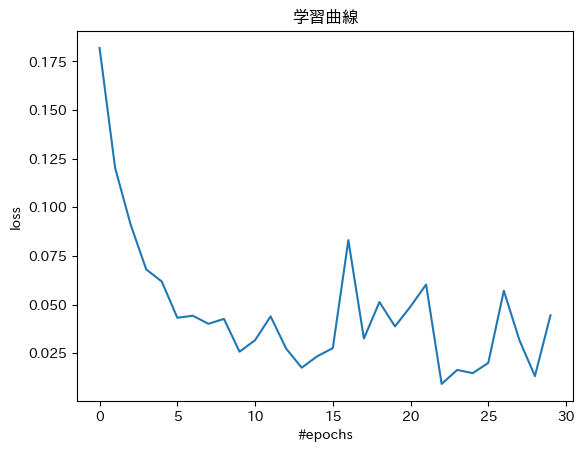

In [8]:
plt.plot(losses)
plt.title('学習曲線')
plt.xlabel('#epochs')
plt.ylabel('loss')

## 学習したパラメタを用いたテスト画像の予測結果

画像の上に正解ラベル (True) と予測したラベル (Pred) を表示している．

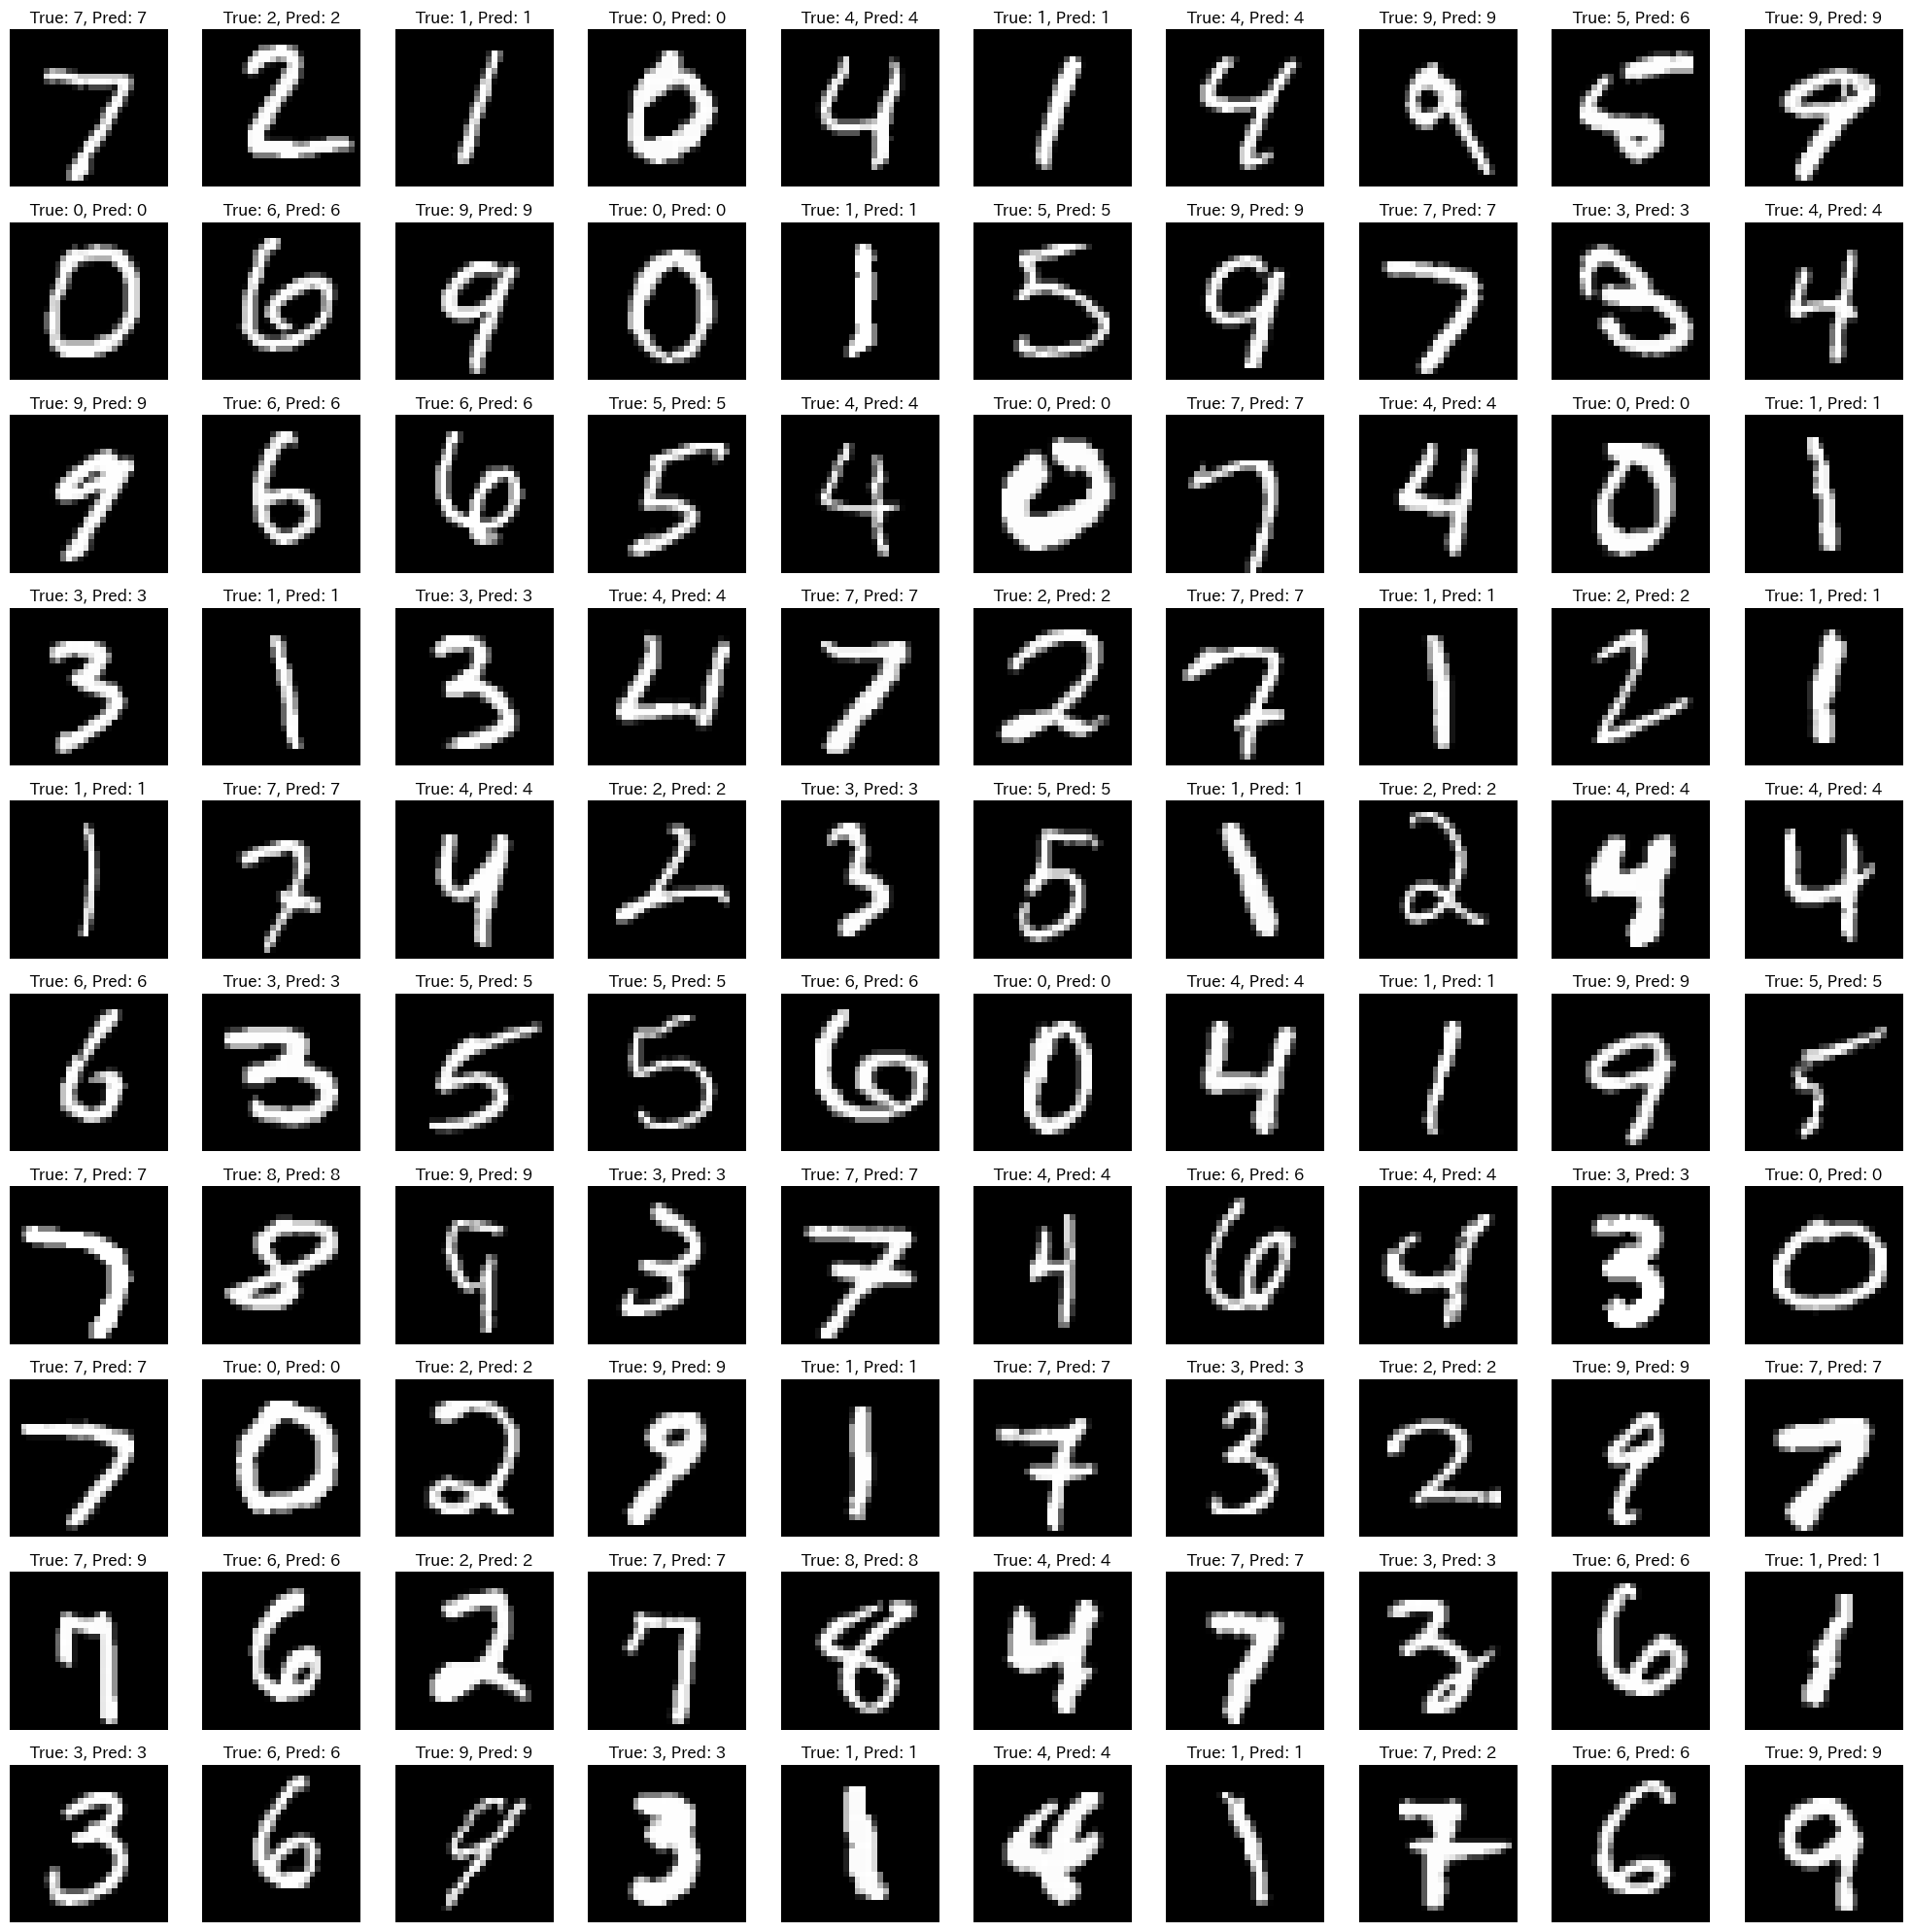

In [9]:
import numpy as np

n_tests = 100

plt.figure(figsize=(20, 20))

for k in range(n_tests):
    img, label = test_data[k]

    y = F.one_hot(torch.tensor(label), num_classes=10).float()
    X = transform(img)
    X, y = X.to(device), y.to(device)

    with torch.no_grad():
        y_pred = F.softmax(model(X).unsqueeze(0), dim=1)
        y_pred = y_pred.cpu().detach().numpy()
        label_pred = np.argmax(y_pred)

    plt.subplot(10, 10, k + 1)
    plt.imshow(img, cmap='gray')
    plt.title('True: ' + str(label) + ', Pred: ' + str(label_pred))
    plt.axis('off')

plt.tight_layout()  # スペースの調整

## 混同行列の表示

テストデータ10000件の分類結果を混同行列としてプロットする．

下図の縦軸が正解ラベル，横軸が予測ラベルを表していて，行列の $(i, j)$ 成分は「正解ラベルが $i$ の画像をラベル $j$ として予測した数」を表している．

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


label_list_pred = []
label_list_true = []

for batch_idx, (X, label) in tqdm(enumerate(test_loader),
                                  total=len(test_loader)):
    with torch.no_grad():
        X = X.to(device)

        y_pred = F.softmax(model(X), dim=1)
        y_pred = y_pred.cpu().detach().numpy()

        label_list_pred.append(np.argmax(y_pred))
    label_list_true.append(label.item())

100%|██████████| 10000/10000 [00:06<00:00, 1622.06it/s]


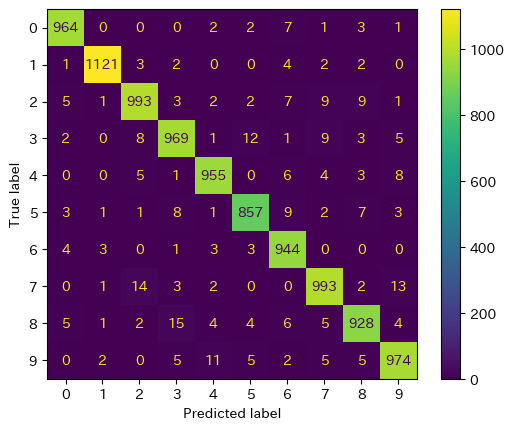

In [11]:
classes = list(range(10))
cm = confusion_matrix(label_list_true, label_list_pred, labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()